# Bank Customer Churn Prediction Challenge 

##  Introduction

Customer churn is a major concern for financial institutions, as retaining existing customers is often more cost-effective than acquiring new one This notebook contains the full end-to-end process of solving a Bank Customer Churn Prediction problem using machine learning. This project was inspired by a Kaggle competition I hosted, where participants were challenged to build predictive models to identify customers likely to churn from a bankn, using demographic and transactional features.

The dataset includes various attributes such as credit score, geography, gender, age, account balance, and customer activity metrics. Our goal is to leverage these features to predict the probability of churn (i.e., `Exited = 1`) and submit our predictions to Kaggle for evaluation.

### Objectives:

- Understand the dataset and perform essential preprocessing.
- Handle class imbalance with SMOTE to ensure fair learning.
- Build and compare multiple machine learning models.
- Select the best-performing model using ROC-AUC score.
- Generate a submission file following the competition format.
- Model Deployment: To use Streamlit to build a simple web interface to receive user inputs and display predictions.

Let’s dive into the data and build a model that makes churn prediction smart and accurate! 


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV


In [4]:
df_train = pd.read_csv('train.csv')
# Let's check the few rows of the dataset 
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15709511.0,Ch'ang,754.0,Spain,Male,40.0,8.0,102954.68,2.0,1.0,1.0,149238.35,0.0
1,1,15592761.0,Genovese,579.0,France,Female,28.0,1.0,0.00,2.0,1.0,0.0,64869.32,0.0
2,2,15579914.0,Yeh,744.0,France,Female,56.0,5.0,0.00,1.0,1.0,0.0,158816.03,1.0
3,3,15669611.0,Nwachinemelu,697.0,France,Male,29.0,2.0,0.00,2.0,1.0,0.0,55775.72,0.0
4,4,15761775.0,Hs?eh,628.0,France,Female,22.0,9.0,0.00,2.0,1.0,0.0,49653.39,0.0


### Dataset Profiling & Initial Insights

In [6]:
def explore_customer(df_train):
    print('Dataset Overview')
    print('Number of Rows:', df_train.shape[0])
    print('Number of Columns:', df_train.shape[1])
    print('-' * 100)
    print('\n Statistical Summary of Numerical Columns')
    print(df_train.describe())
    print('\n Statistical Summary of Categorical Columns')
    print(df_train.describe(include='O'))
    print('-' * 100)
    print('DataTypes & Non Null Values:')
    print(df_train.info())
    print('-' * 100)
    print('Number of missing Values: ')
    print(df_train.isnull().sum())
    return   

In [7]:
explore_customer(df_train)

Dataset Overview
Number of Rows: 15000
Number of Columns: 14
----------------------------------------------------------------------------------------------------

 Statistical Summary of Numerical Columns
                 id    CustomerId   CreditScore           Age        Tenure  \
count  15000.000000  1.500000e+04  15000.000000  15000.000000  15000.000000   
mean    7499.500000  1.579653e+07    658.851467     37.888000      5.033333   
std     4330.271354  1.270937e+07     72.587026      8.257409      2.808359   
min        0.000000  1.556578e+07    431.000000     18.000000      0.000000   
25%     3749.750000  1.563449e+07    602.000000     32.000000      3.000000   
50%     7499.500000  1.569053e+07    662.000000     37.000000      5.000000   
75%    11249.250000  1.575758e+07    709.000000     42.000000      7.000000   
max    14999.000000  1.572242e+09    850.000000     74.000000     10.000000   

             Balance  NumOfProducts     HasCrCard  IsActiveMember  \
count   15000.

### Exploratory Data Analysis [EDA]

In [9]:
numerical_cols = df_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df_train.select_dtypes(include='O')

In [10]:
def numercal_distribution(df_train):
    if not numerical_cols: 
        print('No valid numerical columns to Plot')
        return

    print('Distribution of Numerical Columns:')
    df_train[numerical_cols].hist(figsize=(15, 10), bins=30)
    plt.tight_layout()
    plt.title('Distribution of Numerical Columns')
    plt.savefig('Distribution of Numerical Columns.PNG')
    plt.show()

    print('Numerical Columns Correlation Heatmap:')
    plt.figure(figsize=(15,10))
    sns.heatmap(df_train[numerical_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Numerical Columns Correlation Heatmap')
    plt.savefig('Numerical Columns Correlation Heatmap.PNG')
    plt.show()

    print('Numerical Columns Boxplot:')
    plt.figure(figsize=(15, 10))
    df_train[numerical_cols].boxplot()
    plt.title('Numerical Columns Boxplot')
    plt.savefig('Numerical Columns Boxplot.PNG')
    plt.show()

In [11]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


Distribution of Numerical Columns:


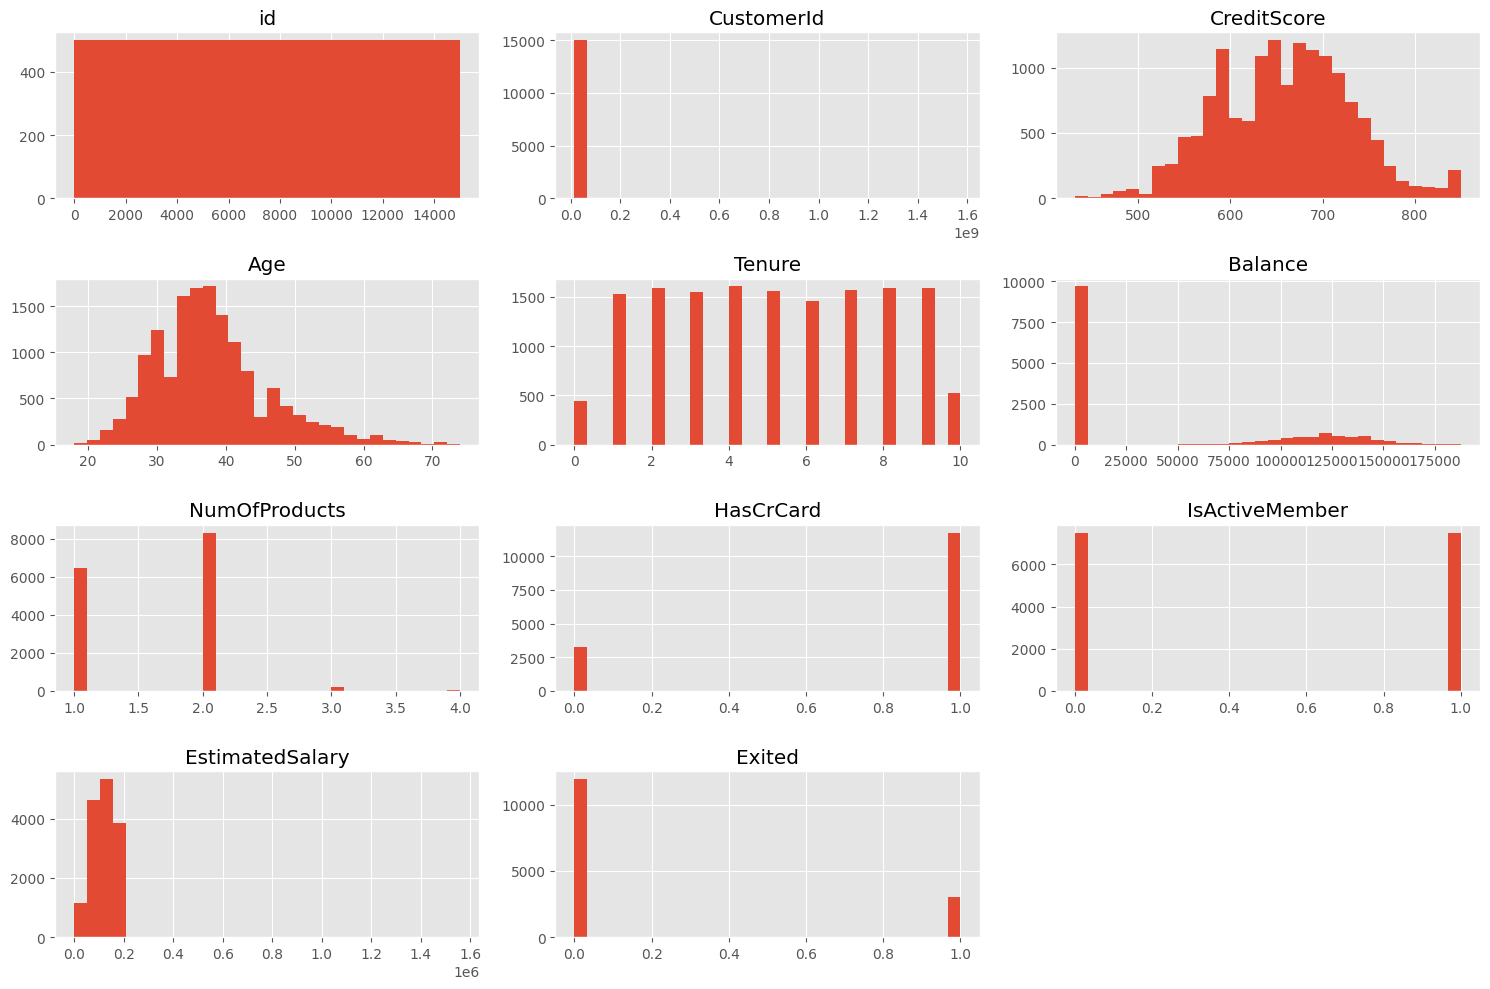

Numerical Columns Correlation Heatmap:


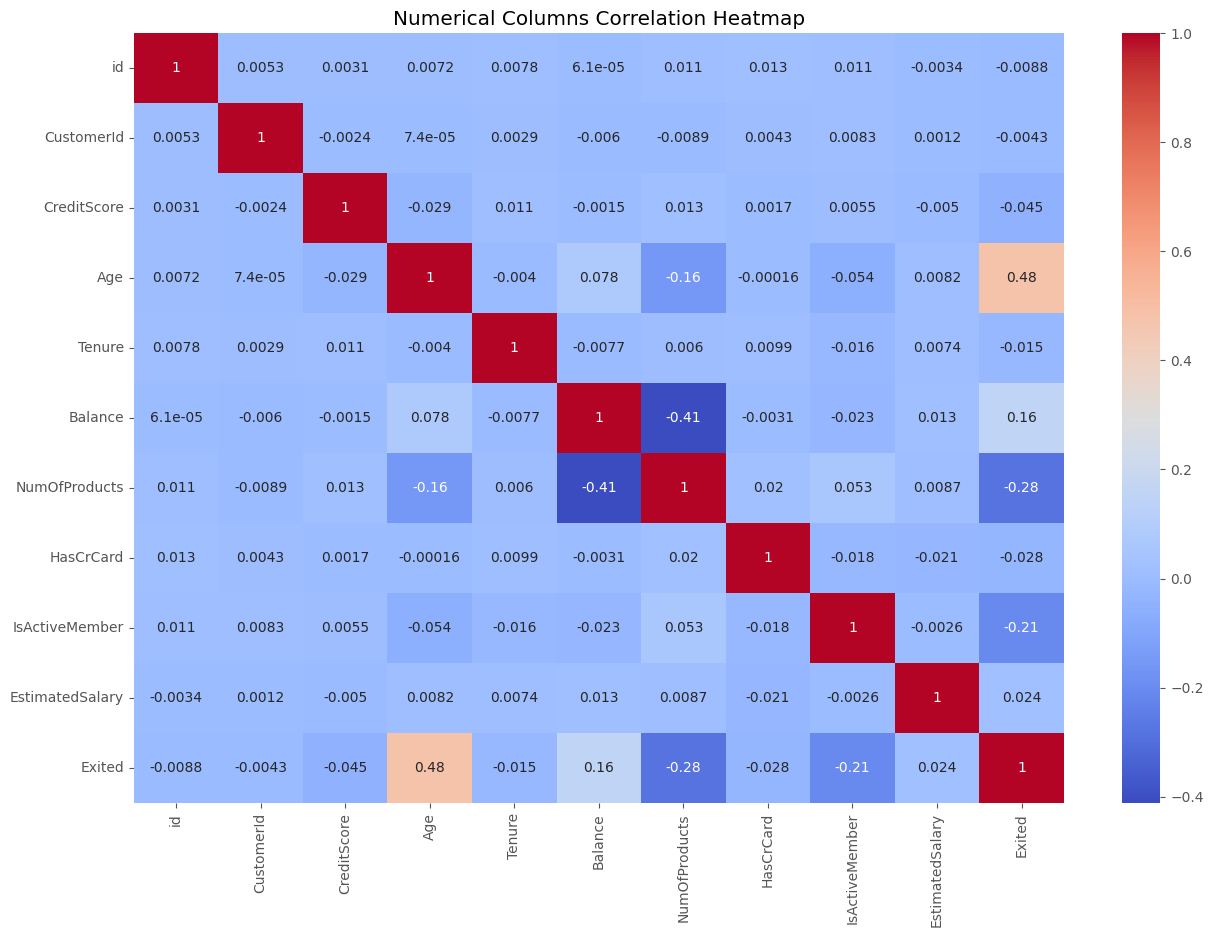

Numerical Columns Boxplot:


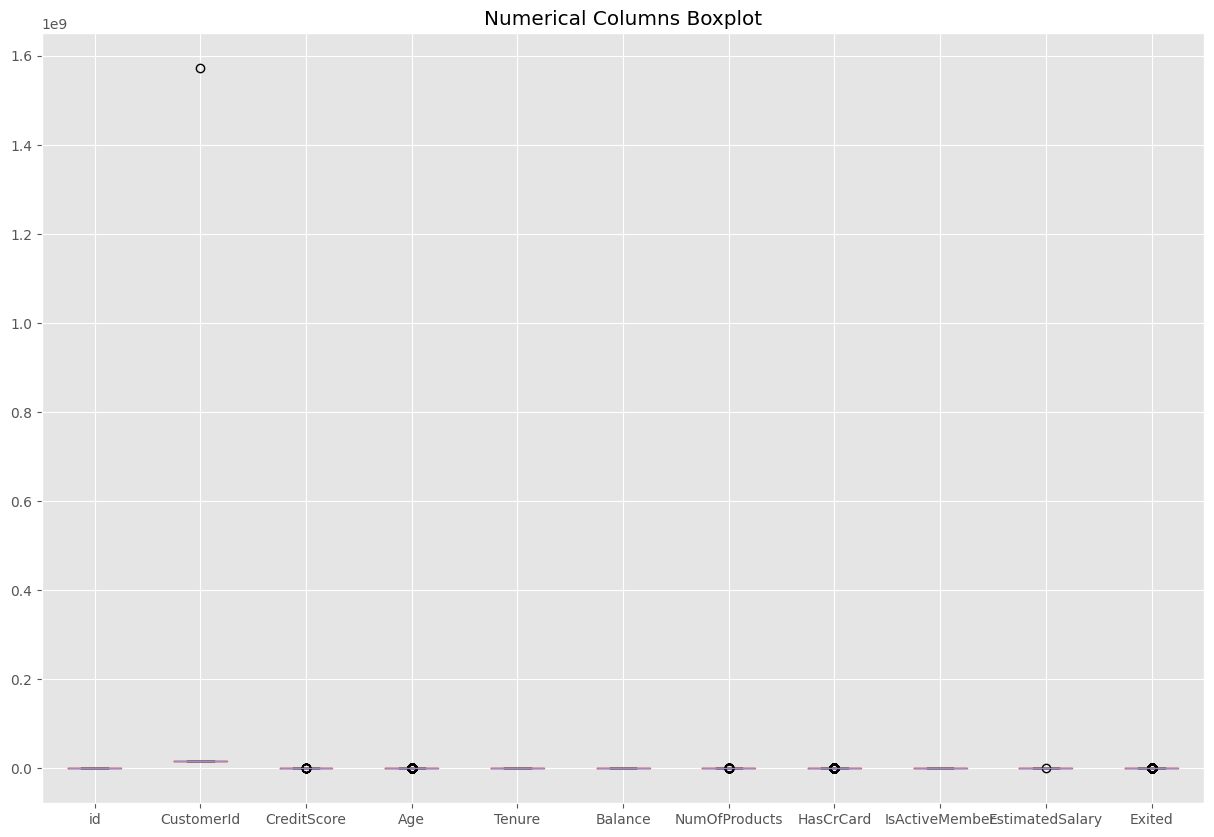

In [12]:
numercal_distribution(df_train)

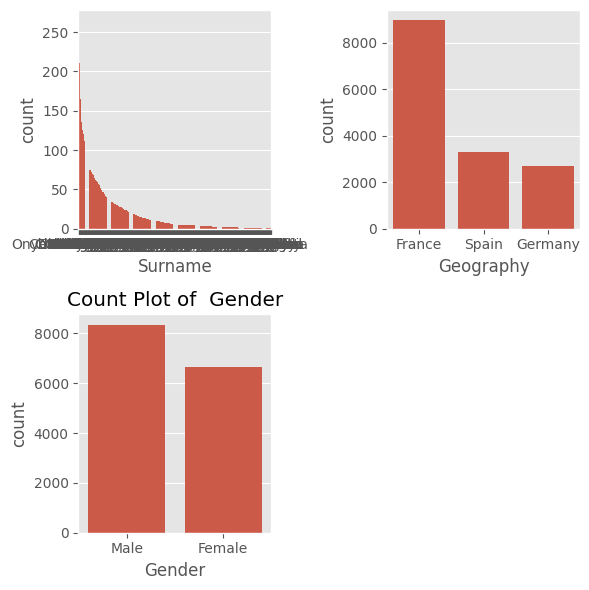

In [13]:
# Let's check Categorical  Columns distribution 
plt.figure(figsize=(6,6))
for idx, col in enumerate(categorical_cols, 1): 
    plt.subplot(2,2,idx)
    sns.countplot(x=df_train[col], order=df_train[col].value_counts().index)
plt.title(f"Count Plot of  {col}")
plt.tight_layout()
plt.show()

### Data Preprocessing

In [15]:
# We need to drop some columns that are not irrelevant for our Model.
df_train.drop(columns=['id',  'CustomerId', 'Surname'], inplace=True)

# Let's handle categorical variables: 
# We will use ONE-HOT ENCODING for Geography Column 
df_train = pd.get_dummies(df_train, columns=['Geography'], drop_first= True)

# Let's convert the newly created dummy columns to integers
geo_cols = [col for col in df_train.columns if col.startswith('Geography_')]
df_train[geo_cols] = df_train[geo_cols].astype(int)

#Encoding the Gender Column 
encoder = LabelEncoder()
df_train['Gender'] = encoder.fit_transform(df_train['Gender'])


<IPython.core.display.Javascript object>

### Model Creation 

In [17]:
# Splitting of dataset to Train-Test Sets
X = df_train.drop(columns=['Exited'])
y = df_train['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<IPython.core.display.Javascript object>

In [18]:
# Let's check the distribution  of the target (Exited Column)
print('Exited Column Distribution \n', y.value_counts())

Exited Column Distribution 
 Exited
0.0    11942
1.0     3058
Name: count, dtype: int64


- The Target  is highly imbalance, so will apply oversampling method to handle the imbalance

In [20]:
from imblearn.over_sampling import SMOTE
# Initializing SMOTE
smote = SMOTE()
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [21]:
# Initializing multiple models 
models = {'Logistics Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(max_depth=100),
        'Random Forest': RandomForestClassifier(random_state=42), 
        'KNN': KNeighborsClassifier(), 
        'Xgboost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)}

# Training and evaluating Models
roc_scores = {}

for name, model in models.items():
    model.fit(X_train_resample, y_train_resample)  # Training the  models
    y_probs = model.predict_proba(X_test)[:, 1]  # Getting probabilities for class 1
    roc_auc = roc_auc_score(y_test, y_probs)
    roc_scores[name] = roc_auc
    print(f"{name} ROC-AUC Score: {roc_auc:.4f}")

<IPython.core.display.Javascript object>

Logistics Regression ROC-AUC Score: 0.8714
Decision Tree ROC-AUC Score: 0.7797
Random Forest ROC-AUC Score: 0.9215
KNN ROC-AUC Score: 0.5704
Xgboost ROC-AUC Score: 0.9242


In [22]:
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train_resample, y_train_resample)
y_probs = best_model.predict_proba(X_test)[:,1]
# Best Model Evaluation 
roc_auc = roc_auc_score(y_test, y_probs)
print(f'Best Model ROC-AUC Score: {roc_auc:.4f}')

<IPython.core.display.Javascript object>

Best Model ROC-AUC Score: 0.9215


In [23]:
# Let's load the test data 
df_test = pd.read_csv('test.csv')

# We will apply same data preprocessing on the Test data as we did on the train dataset.

# Dropping irrelevant columns  
X_test_data = df_test.drop(columns=['id', 'CustomerId', 'Surname'])

# Let's encode the Categorical Columns 
X_test_data = pd.get_dummies(X_test_data, columns=['Geography'], drop_first=True)

# Let's convert the newly created dummy columns to integers
geog_cols = [col for col in X_test_data.columns if col.startswith('Geography_')]
X_test_data[geog_cols] = X_test_data[geog_cols].astype(int)

# Encoding the Gender Column 
X_test_data['Gender'] = encoder.fit_transform(df_test['Gender'])

# Let's predict Probability 
y_test_probs = best_model.predict_proba(X_test_data)[:, 1]

In [24]:
# # Let's prepare submission file
# submission = pd.DataFrame({'id':df_test['id'], 'Exited':y_test_probs})
# submission.to_csv('Submission2.csv', index=False)


### Hyperparameter Tuning for Random Forest

In [26]:
# Let's define the parameters
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = best_model 

rf_random = RandomizedSearchCV(rf, param_distributions=param_grid_rf, scoring='roc_auc', 
                              n_iter=10, cv=3, verbose=1) 
rf_random.fit(X_train_resample, y_train_resample)

best_rf = rf_random.best_estimator_
best_rf

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomForestClassifier(bootstrap=False, n_estimators=300, random_state=42)

In [27]:
# Let's train the Model with Hyperparameter
best_model_cv = RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_leaf=5, n_estimators=300, random_state=42)

best_model_cv.fit(X_train_resample, y_train_resample)
y_probs_cv = best_model_cv.predict_proba(X_test)[:, 1]
roc_auc_cv = roc_auc_score(y_test, y_probs_cv)
print(f"RF Hyperparameter Tuning ROC-AUC Score: {roc_auc_cv:.4f}")

<IPython.core.display.Javascript object>

RF Hyperparameter Tuning ROC-AUC Score: 0.9287


In [28]:
# Let's now evaluate the model  on the test data 
y_probs_cv = best_model_cv.predict_proba(X_test_data)[:, 1]
cv_submission  = pd.DataFrame({'id': df_test['id'], 'Exited':y_probs_cv})
cv_submission.to_csv('submission3.csv', index=False)

### Conclusion
This project focused on predicting customer churn using machine learning techniques. After preprocessing the dataset, addressing class imbalance with SMOTE, and testing multiple models, we found:

- Random Forest gave the best performance with a base ROC-AUC of 0.9245.

- After hyperparameter tuning, the model's performance improved to a ROC-AUC of 0.9290.

This indicates strong discriminatory power in identifying customers likely to churn.

Our workflow included:

- Data Cleaning & Preprocessing

- Encoding Categorical Variables

- Addressing Imbalanced Classes

- Model Training & Evaluation (ROC-AUC)

- Hyperparameter Tuning with RandomizedSearchCV

*The final model demonstrates reliability for deployment in a real-world setting to proactively
identify at-risk customers and potentially reduce churn through strategic interventions.*

*Next, the model will be packaged and deployed using a lightweight web service to serve predictions in real-time.*

### Model Deployment Setup with Streamlit

In this final section, I prepare the trained model for deployment using **Streamlit**, a Python library for building interactive web apps.

Key steps include:
- Saving the trained model and preprocessing pipeline using `joblib` & `pickle`.
- Creating a script (`app.py`) that loads the model, accepts user inputs, and returns predictions.
- Building an intuitive front-end with Streamlit for end-user interaction.

In [31]:
# We will use  joblib or pickle to save the best-performing model:
import joblib 
import streamlit as st
import pickle

In [32]:
# Saving the trained model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(best_model_cv, f)

# Loading  model
model = joblib.load('rf_model.pkl')
st.title('Customer Churn Prediction')

# Collect user input

st.title("Customer Churn Prediction App")

st.header("Enter Customer Information")

# Numerical Inputs
credit_score = st.number_input("Credit Score", min_value=300, max_value=850, value=600)
age = st.number_input("Age", min_value=18, max_value=100, value=35)
tenure = st.number_input("Tenure (Years with bank)", min_value=0, max_value=10, value=3)
balance = st.number_input("Account Balance", min_value=0.0, value=50000.0)
num_of_products = st.selectbox("Number of Products", [1, 2, 3, 4])
has_cr_card = st.radio("Has Credit Card?", [1, 0])  # 1 = Yes, 0 = No
is_active_member = st.radio("Is Active Member?", [1, 0])  # 1 = Yes, 0 = No
estimated_salary = st.number_input("Estimated Salary", min_value=0.0, value=60000.0)

# Categorical Inputs
gender = st.selectbox("Gender", ["Male", "Female"])
geography = st.selectbox("Geography", ["France", "Germany", "Spain"])

# Encode gender
gender_encoded = 1 if gender == "Male" else 0

# One-hot encode geography manually
geo_germany = 1 if geography == "Germany" else 0
geo_spain = 1 if geography == "Spain" else 0
# France is baseline, so both 0

# Combine all features into final input array
features = np.array([[credit_score, gender_encoded, age, tenure, balance,
                      num_of_products, has_cr_card, is_active_member,
                      estimated_salary, geo_germany, geo_spain]])

# Predict
# Load  trained model
with open("rf_model.pkl", "rb") as file:
    model = pickle.load(file)

# Make prediction
if st.button("Predict Churn"):
    prediction = model.predict(features)
    probability = model.predict_proba(features)[0][1]

    if prediction[0] == 1:
        st.error(f"⚠️ This customer is likely to churn. Probability: {probability:.2f}")
    else:
        st.success(f"✅ This customer is likely to stay. Probability: {probability:.2f}")


2025-04-12 03:10:37.292 
  command:

    streamlit run C:\Users\DELL\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


### 🔗 Links & Resources:
- [![Streamlit App](https://img.shields.io/badge/Streamlit-App%20Live-brightgreen?logo=streamlit)](https://bank-customer-churn-prediction-app-szvevdugbfdd8q6oghpuvj.streamlit.app/)
- **Live App:** [Bank Customer Churn Prediction App](https://bank-customer-churn-prediction-app-szvevdugbfdd8q6oghpuvj.streamlit.app/)
- **App Deployment Repository:** [bank-churn-streamlit-deployment](https://github.com/FijabiAdekunle/bank-churn-streamlit-deployment)

### 📸 App Preview

![App Screenshot](https://i.postimg.cc/m2WmG5D4/Bank-Customer-Churn-Pred-Web-App-Snapshot.png)  
<sub>_Screenshot of the deployed Streamlit app interface_</sub>

> This deployment demonstrates how the machine learning pipeline can be integrated into real-world tools for practical use cases.
